In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import random

In [4]:
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 32
LEARNING_RATE = .001
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(SEED)

numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
all_vars = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

In [5]:
# Loading the data
scaler = MinMaxScaler()

df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Transforming the data to tensors
X_train_val = torch.from_numpy(X_train_val).float()
y_train_val = torch.from_numpy(y_train_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Splitting train_val into train and val 
##### LATER MAYBE KFOLD???
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42, shuffle=True)

# Reshaping the outcomes to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
#y_train_val = y_train_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Creating datasets from the tensors
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
#train_val_data = TensorDataset(X_train_val, y_train_val)
test_data = TensorDataset(X_test, y_test)

# Creating data loaders
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)
#train_val_dataloader = DataLoader(train_val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)

In [6]:
list(df_test.columns)

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [11]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * TRAIN_BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate_model(dataloader, model, loss_fn, is_test=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    correct = 0
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            pred = pred.sigmoid().round()
            correct += (pred == y).type(torch.float).sum().item()
            preds.append(pred.cpu())
            labels.append(y.cpu())
            
    preds = torch.cat(preds)              
    labels = torch.cat(labels)      
    loss /= num_batches
    correct /= size
    f1 = f1_score(labels, preds)
    balanced_acc = balanced_accuracy_score(labels, preds)
    print(f"Test Error: \n Accuracy: {(100*correct):.2f}%, \n Avg loss: {loss:.4f}, \n f1 score: {f1:.4f} \n Balanced accuracy: {balanced_acc:.4f} \n")
    
    if not is_test:
        return loss, f1, balanced_acc


In [42]:
# Small neural network for each feature
class FeatureNet(nn.Module):
    def __init__(self, input_dim=1, hidden_num=1, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.net(x)

# NAM model
class NAM(nn.Module):
    def __init__(self, num_features, hidden_num=1, hidden_dim=32):
        super().__init__()
        self.feature_nets = nn.ModuleList([
            FeatureNet(input_dim=1, hidden_num=hidden_num, hidden_dim=hidden_dim)
            for _ in range(num_features)
        ])

    def forward(self, x):
        # x: (batch_size, num_features)
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.feature_nets)]
        out = torch.stack(outputs, dim=1).sum(dim=1)  # sum across features
        return out

In [9]:
# Small neural network for each feature
class FeatureNet(nn.Module):
    def __init__(self, input_dim=1, hidden_num=1, hidden_dim=32):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        
        for _ in range(hidden_num - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, input_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# NAM model
class NAM(nn.Module):
    def __init__(self, num_features, hidden_num=1, hidden_dim=32):
        super().__init__()
        self.feature_nets = nn.ModuleList([
            FeatureNet(input_dim=1, hidden_num=hidden_num, hidden_dim=hidden_dim)
            for _ in range(num_features)
        ])

    def forward(self, x):
        # x: (batch_size, num_features)
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.feature_nets)]
        out = torch.stack(outputs, dim=1).sum(dim=1)  # sum across features
        return out

In [56]:
hidden_nums = [1, 2, 3]
hidden_dims = [16, 32]
num_epochs = 10

scores = pd.DataFrame(columns=["hidden_layers", "hidden_units", "epochs", "loss", "f1", "balanced_acc"])
for hidden_num in hidden_nums:
    for hidden_dim in hidden_dims:
        print(f"MODEL: hidden_num: {hidden_num}, hidden_dim: {hidden_dim}\n\n")
        
        model = NAM(11, hidden_num=hidden_num, hidden_dim=hidden_dim)
        loss_fn = BCEWithLogitsLoss()
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
        
        losses = []
        f1s = []
        balanced_accs = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_one_epoch(train_dataloader, model, loss_fn, optimizer)
            loss, f1, balanced_acc = evaluate_model(val_dataloader, model, loss_fn)
            losses.append(loss)
            f1s.append(f1)
            balanced_accs.append(balanced_acc)
        
        for i, (loss, f1, balanced_acc) in enumerate(zip(losses, f1s, balanced_accs)):
            scores.loc[len(scores)] = [int(hidden_num), int(hidden_dim), int(i+1), loss, f1, balanced_acc]

print("Done!")

MODEL: hidden_num: 1, hidden_dim: 16


Epoch 1
-------------------------------
loss: 0.654640  [   16/  587]
loss: 0.728840  [  176/  587]
loss: 0.595586  [  336/  587]
loss: 0.554092  [  496/  587]
Test Error: 
 Accuracy: 82.99%, 
 Avg loss: 0.5400, 
 f1 score: 0.8521 
 Balanced accuracy: 0.8258 

Epoch 2
-------------------------------
loss: 0.559787  [   16/  587]
loss: 0.532529  [  176/  587]
loss: 0.441327  [  336/  587]
loss: 0.459578  [  496/  587]
Test Error: 
 Accuracy: 83.67%, 
 Avg loss: 0.4300, 
 f1 score: 0.8400 
 Balanced accuracy: 0.8370 

Epoch 3
-------------------------------
loss: 0.598005  [   16/  587]
loss: 0.334365  [  176/  587]
loss: 0.618199  [  336/  587]
loss: 0.381292  [  496/  587]
Test Error: 
 Accuracy: 82.99%, 
 Avg loss: 0.3790, 
 f1 score: 0.8428 
 Balanced accuracy: 0.8281 

Epoch 4
-------------------------------
loss: 0.242259  [   16/  587]
loss: 0.482096  [  176/  587]
loss: 0.407457  [  336/  587]
loss: 0.420443  [  496/  587]
Test Error: 
 Accu

In [57]:
scores

,hidden_layers,hidden_units,epochs,loss,f1,balanced_acc
0,1.0,16.0,1.0,0.539953,0.852071,0.825797
1,1.0,16.0,2.0,0.429974,0.840000,0.837009
2,1.0,16.0,3.0,0.379007,0.842767,0.828113
3,1.0,16.0,4.0,0.357691,0.855263,0.850167
4,1.0,16.0,5.0,0.369288,0.878981,0.869440
5,1.0,16.0,6.0,0.344743,0.853333,0.850630
6,1.0,16.0,7.0,0.336250,0.875817,0.870367
7,1.0,16.0,8.0,0.342860,0.843537,0.844514
8,1.0,16.0,9.0,0.330410,0.875817,0.870367
9,1.0,16.0,10.0,0.323747,0.875817,0.870367


In [58]:
max_f1 = scores.loc[:, 'f1'].max()
max_balanced_acc = scores.loc[:, "balanced_acc"].max()
best_scores = scores[scores["balanced_acc"] == max_balanced_acc].reset_index()
best_hidden_num = int(best_scores.loc[0, "hidden_layers"])
best_hidden_dim = int(best_scores.loc[0, "hidden_units"])
best_num_epochs = int(best_scores.loc[0, "epochs"])
best_scores


,index,hidden_layers,hidden_units,epochs,loss,f1,balanced_acc
0,16,1.0,32.0,7.0,0.334655,0.890323,0.883525


Epoch 1
-------------------------------
loss: 0.595768  [   16/  587]
loss: 0.651402  [  176/  587]
loss: 0.595164  [  336/  587]
loss: 0.716623  [  496/  587]
Test Error: 
 Accuracy: 77.55%, 
 Avg loss: 0.5864, 
 f1 score: 0.8197 
 Balanced accuracy: 0.7681 

Epoch 2
-------------------------------
loss: 0.580892  [   16/  587]
loss: 0.564824  [  176/  587]
loss: 0.592202  [  336/  587]
loss: 0.536251  [  496/  587]
Test Error: 
 Accuracy: 85.03%, 
 Avg loss: 0.4639, 
 f1 score: 0.8642 
 Balanced accuracy: 0.8479 

Epoch 3
-------------------------------
loss: 0.456500  [   16/  587]
loss: 0.388494  [  176/  587]
loss: 0.486965  [  336/  587]
loss: 0.427797  [  496/  587]
Test Error: 
 Accuracy: 87.07%, 
 Avg loss: 0.3854, 
 f1 score: 0.8774 
 Balanced accuracy: 0.8699 

Epoch 4
-------------------------------
loss: 0.262471  [   16/  587]
loss: 0.296849  [  176/  587]
loss: 0.314289  [  336/  587]
loss: 0.569041  [  496/  587]
Test Error: 
 Accuracy: 86.39%, 
 Avg loss: 0.3594, 
 f1 

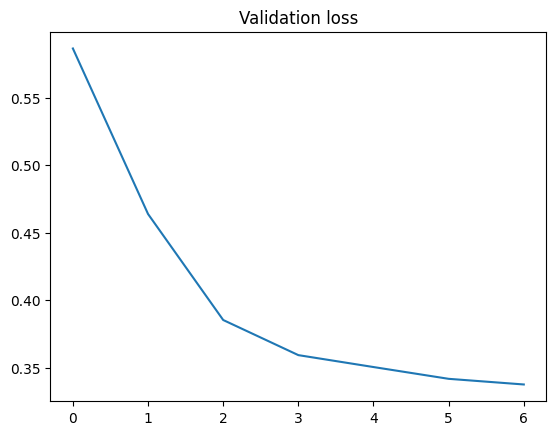

In [59]:
#model = NAM(11, hidden_num=2, hidden_dim=32)
model = NAM(11, hidden_num=best_hidden_num, hidden_dim=best_hidden_dim)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(best_num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    loss, _, _ = evaluate_model(val_dataloader, model, loss_fn)
    losses.append(loss)

print("Done!")

plt.plot(losses)
plt.title("Validation loss")
plt.show()

In [60]:
model.eval()
evaluate_model(test_dataloader, model, loss_fn, is_test=True)

Test Error: 
 Accuracy: 82.61%, 
 Avg loss: 0.3982, 
 f1 score: 0.8545 
 Balanced accuracy: 0.8192 



### 32 hidden dim 5 epochs
Test Error: 
 Accuracy: 83.15%, 
 Avg loss: 0.4099, 
 f1 score: 0.8584 
 Balanced accuracy: 0.8259 

 ### 64 hidden dim 5 epochs
Test Error: 
 Accuracy: 84.24%, 
 Avg loss: 0.3926, 
 f1 score: 0.8711 
 Balanced accuracy: 0.8306 

# Visualizing the model

In [39]:
def visualize_feature(model, feature_index, feature_name, ax, num_categories=None, x_range=(0, 1), num_points=100):
    net = model.feature_nets[feature_index]
    with torch.no_grad():
        if num_categories is None:
            numerical_index = numerical_vars.index(feature_name)
            data_min = scaler.data_min_[numerical_index]
            data_max = scaler.data_max_[numerical_index]
            
            x_vals = torch.linspace(*x_range, steps=num_points).unsqueeze(1)
            y_vals = net(x_vals).squeeze()
            x_vals_original = x_vals * (data_max - data_min) + data_min
            ax.plot(x_vals_original.numpy(), y_vals.numpy())
        
        else:
            x_vals = torch.arange(num_categories).float().view(-1, 1)
            y_vals = net(x_vals).squeeze().numpy()
            ax.bar(x_vals.squeeze().numpy(), y_vals)
            #ax.set_xticks(num_categories)
        
        ax.set_title(feature_name)
        ax.set_xlabel(feature_name)
        ax.set_ylabel(f"{feature_name} contribution")

def visualize_numerical_feature(model, feature_index, ax, feature_name=None, x_range=(0, 1), num_points=100):
    if feature_name is None:
        feature_name = f"Feature {feature_index}"
        
    x_vals = torch.linspace(*x_range, steps=num_points).unsqueeze(1)
    with torch.no_grad():
        y_vals = model.feature_nets[feature_index](x_vals).squeeze()
    ax.plot(x_vals.numpy(), y_vals.numpy())
    ax.title(feature_name)
    ax.xlabel(feature_name)
    ax.ylabel(f"{feature_name} contribution")
    plt.show()
    

def visualize_ordinal_feature(model, feature_index, num_categories, ax):
    values = torch.arange(num_categories).float().view(-1, 1)
    net = model.feature_nets[feature_index]

    with torch.no_grad():
        contributions = net(values).squeeze().numpy()

    ax.bar(range(num_categories), contributions)
    ax.xlabel("Category Index")
    ax.ylabel("Contribution to logit")
    ax.title(f"Ordinal Feature {feature_index}")
    plt.show()

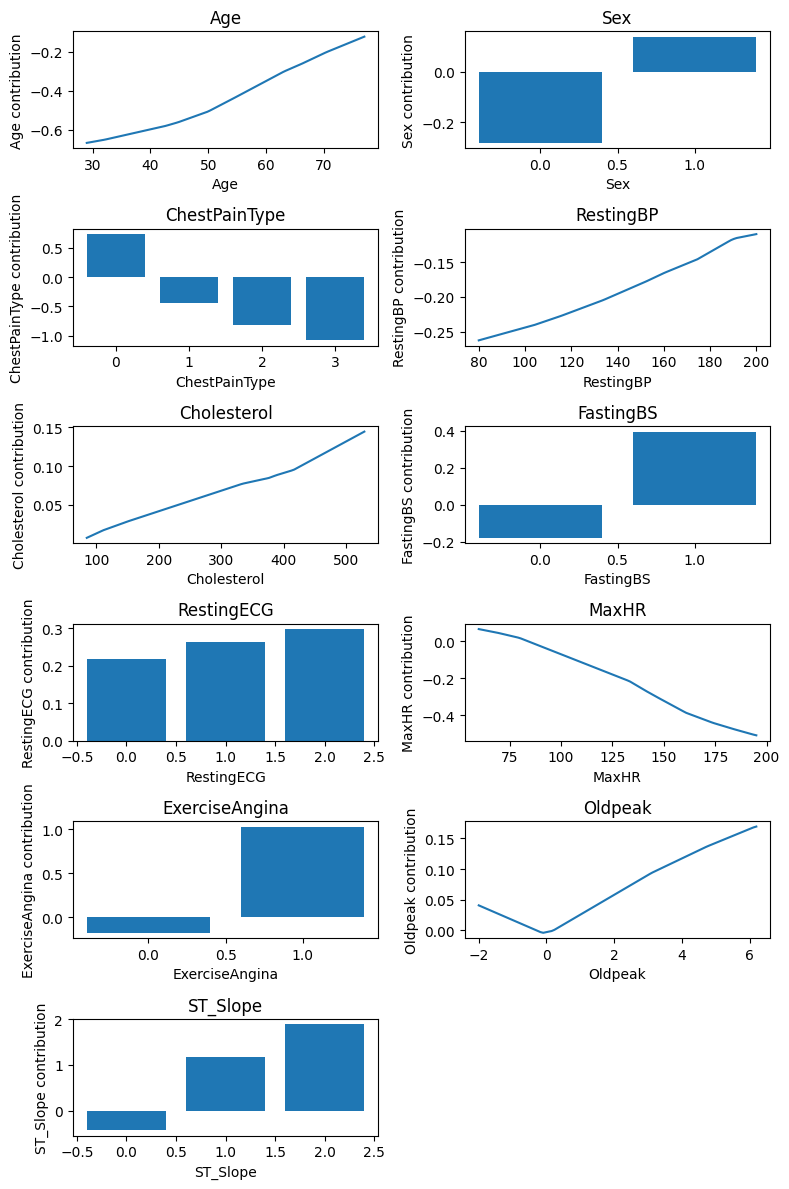

In [41]:
fig, axs = plt.subplots(6, 2, figsize=(8, 12))
for k, var in enumerate(all_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    num_categories = None
    if var in categorical_vars:
        num_categories = len(df_test[var].unique())
    visualize_feature(model, k, var, axs[i, j], num_categories=num_categories)

axs[5, 1].set_visible(False)
plt.tight_layout()
plt.show()